In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale

import xgboost as xgb

c:\Users\vladka\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data_awake = pd.read_csv('data/awake.csv')

In [3]:
data_awake.head()

doc_name                       data_name interval_name      bi_2  \
0  LT1D-0.03.nex  fon15_nw_minus_1_15__minus_1_1         fon15 -0.337455   
1  LT1D-0.03.nex  fon17_nw_minus_3_17__minus_1_1         fon17  0.057785   
2  LT1D-0.28.nex    fon_nw_minus_1_15__minus_1_1           fon -0.060714   
3  LT1D-0.28.nex    fon_nw_minus_1_15__minus_1_2           fon -0.027258   
4  LT1D-0.28.nex    fon_nw_minus_3_16__minus_1_1           fon -0.072738   

   burst_behaviour  burst_index  burst_mean  burst_oscore_12.0_20.0  \
0         0.452632     0.233696    0.627360               -1.000000   
1         0.356522     0.009281    0.686349                1.630167   
2         0.442857     0.019324    0.928396                0.000022   
3         0.514286     0.075419    0.847157                0.221285   
4         0.550000     4.389381    0.677979                0.120744   

   burst_oscore_20.0_30.0  burst_oscore_3.0_8.0  ...    oscore_20.0_30.0  \
0               -1.000000             23.613983  ...            0.871078   
1                1.775803             10.958032  ...            1.962783   
2                0.706479             11.384785  ...            0.823967   
3                0.091573             19.770661  ...            0.355301   
4                0.142614              5.975898  ...            0.402140   

   oscore_3.0_8.0  oscore_30.0_60.0  oscore_60.0_90.0  oscore_8.0_12.0  \
0        7.266619          1.631565          2.584953         2.800303   
1        5.232259          1.591019          1.226974         2.379424   
2        1.765436          2.709362          2.967581         1.265968   
3        2.117879          0.842463          1.974708         2.161458   
4        2.857175          0.581956          0.707741         2.314900   

   pause_index  pause_ratio  skewness  spike_count   type  
0     0.127389     0.136642  4.507920          355  burst  
1     0.241935     0.257966  2.514451          694  burst  
2     0.049828     0.051762  0.997215          612  tonic  
3     0.018987     0.019785  1.600517          806  tonic  
4     0.004232     0.004445  2.421919         1662  burst  

[5 rows x 41 columns]

In [4]:
data_awake = data_awake.drop(['doc_name', 'interval_name', 'data_name', 'spike_count', 'filter_length'], axis=1)

In [5]:
data_sleep = pd.read_csv('data/sleep.csv')

In [6]:
data_sleep = data_sleep.drop(['doc_name', 'data_name', 'interval_name', 'spike_count', 'filter_length'], axis=1)

In [7]:
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})

In [8]:
try:
    data_sleep = data_sleep.drop(['ISP_13_30', 'ISP_1_3', 'ISP_30_100', 'ISP_3_8', 'ISP_8_13'], axis=1)
except:
    pass

In [9]:
try:
    data_awake = data_awake.drop(['ISP_13_30', 'ISP_1_3', 'ISP_30_100', 'ISP_3_8', 'ISP_8_13'], axis=1)
except:
    pass

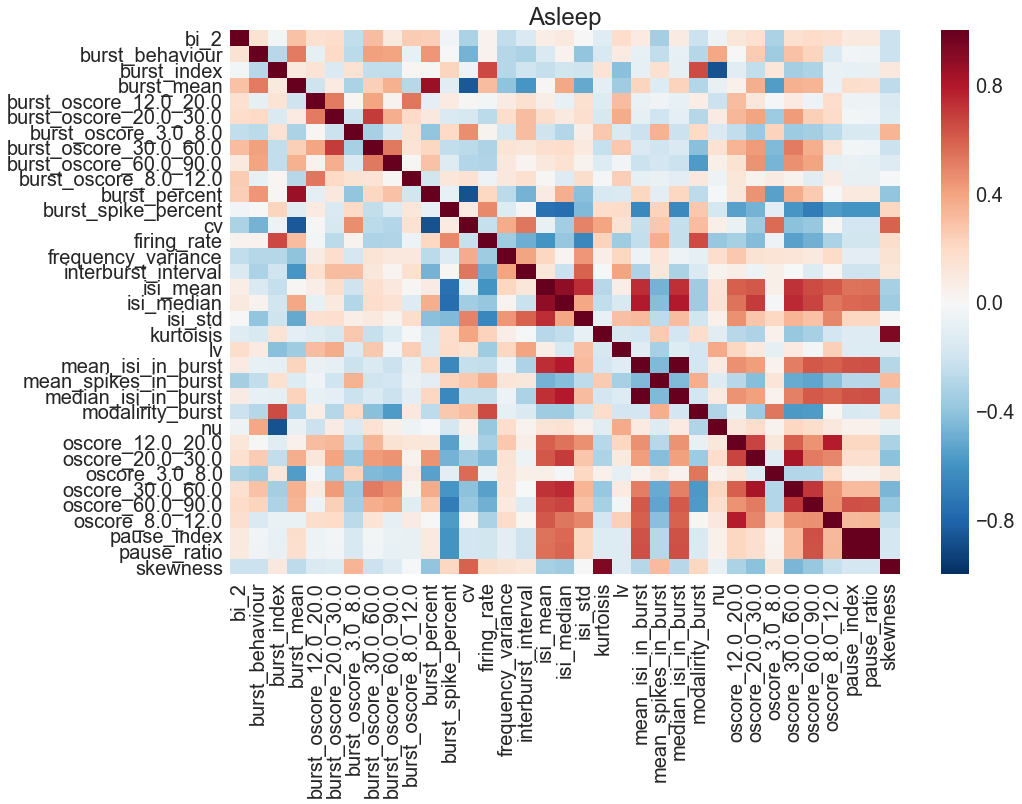

In [10]:
plt.figure(figsize=(15,10))
sns.heatmap(data_sleep.corr())
plt.title('Asleep')

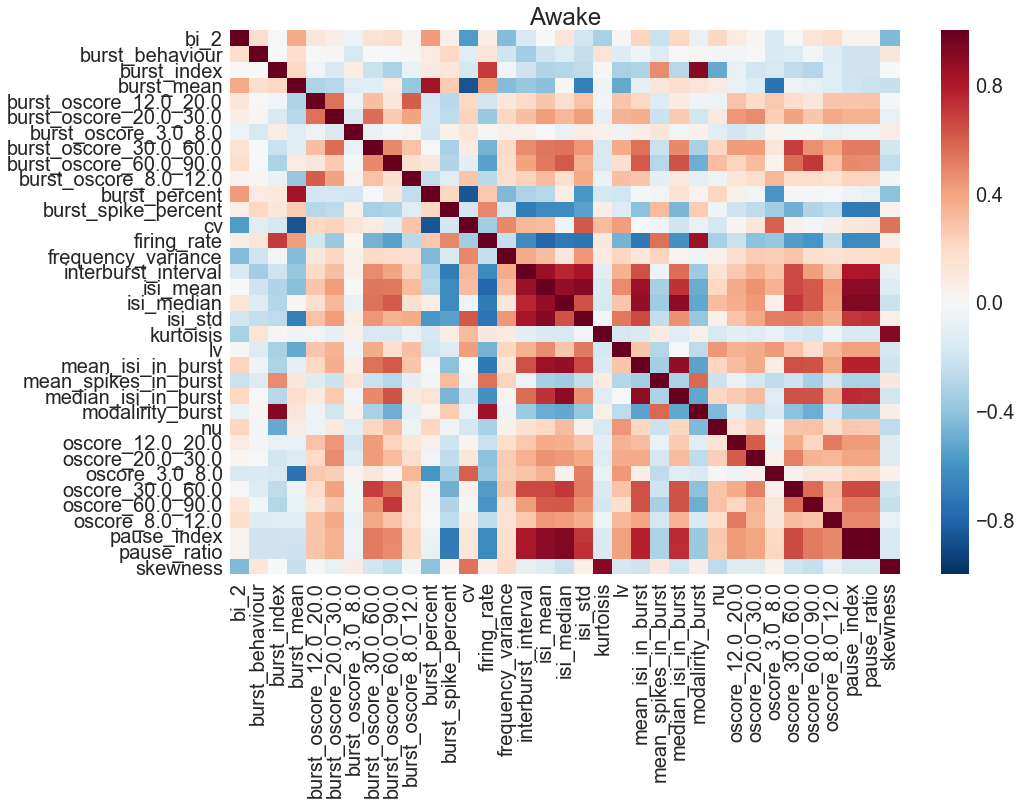

In [11]:
plt.figure(figsize=(15,10))
sns.heatmap(data_awake.corr())
plt.title('Awake')

In [12]:
data_sleep['awake'] = 0
data_awake['awake'] = 1

data = pd.concat([data_sleep, data_awake], ignore_index=True)
data = data.join(pd.get_dummies(data['type'])).drop(['type'], axis=1)

In [13]:
data.to_csv('data_preprocessed.csv', index=False)

In [14]:
X = data.drop(['awake'], axis=1)
y = data['awake']

In [15]:
data.head()

bi_2  burst_behaviour  burst_index  burst_mean  burst_oscore_12.0_20.0  \
0 -0.348143         0.358974     0.085938    0.397226               -1.000000   
1 -0.221781         0.387931     0.028000    0.699645                0.002632   
2  0.024182         0.435897     0.378788    0.514481               -1.000000   
3 -1.573461         0.361702     0.078261    0.375046               -1.000000   
4 -0.191587         0.550000     7.324503    0.728270                0.438809   

   burst_oscore_20.0_30.0  burst_oscore_3.0_8.0  burst_oscore_30.0_60.0  \
0                0.657266             17.091653                5.732228   
1                0.244606             16.218413                0.946193   
2               -1.000000             -1.000000                3.525539   
3                1.248780             -1.000000                1.179215   
4                0.433139             18.755903                0.506376   

   burst_oscore_60.0_90.0  burst_oscore_8.0_12.0  ...    oscore_30.0_60.0  \
0                1.770115              13.430714  ...            5.116324   
1                2.221302              -1.000000  ...            2.091042   
2                2.194431              -1.000000  ...            2.715569   
3                3.503034              -1.000000  ...            2.396420   
4                0.474494               2.433779  ...            0.368765   

   oscore_60.0_90.0  oscore_8.0_12.0  pause_index  pause_ratio  skewness  \
0          3.132216         0.664641     0.403509     0.471453  3.983516   
1          2.108825         0.442727     0.164430     0.177064  5.542609   
2          2.784354         3.919169     0.095890     0.105011  4.594976   
3          2.691669         5.175710     0.165644     0.200820  7.096754   
4          0.532852         4.291382     0.004563     0.004851  4.615793   

   awake  burst  irregular  tonic  
0      0      1          0      0  
1      0      1          0      0  
2      0      1          0      0  
3      0      1          0      0  
4      0      0          1      0  

[5 rows x 39 columns]

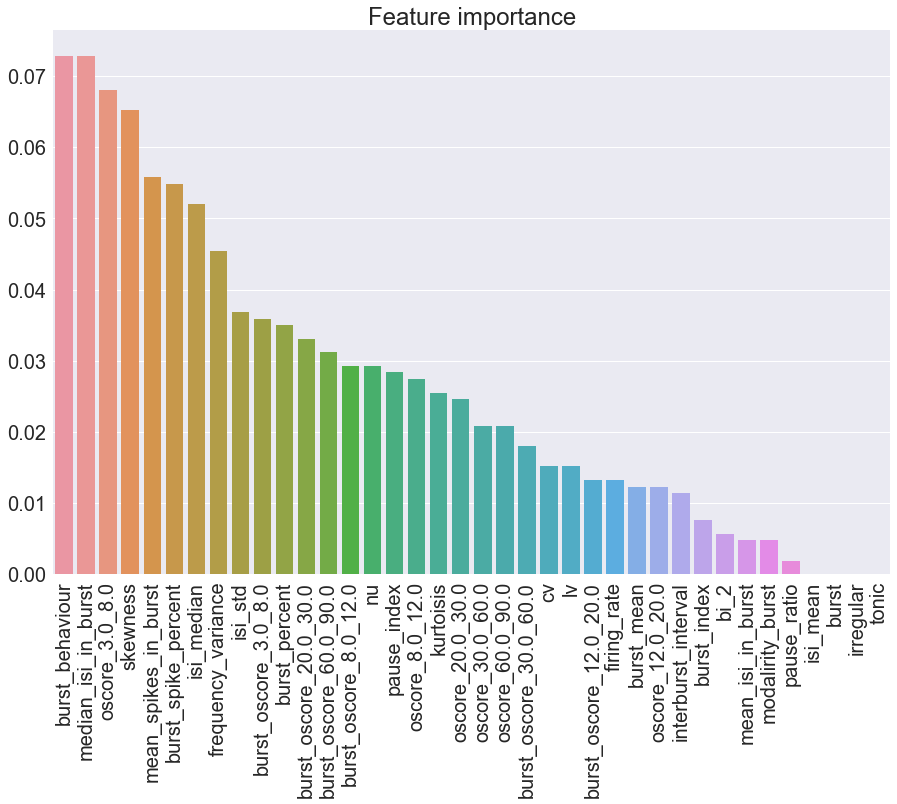

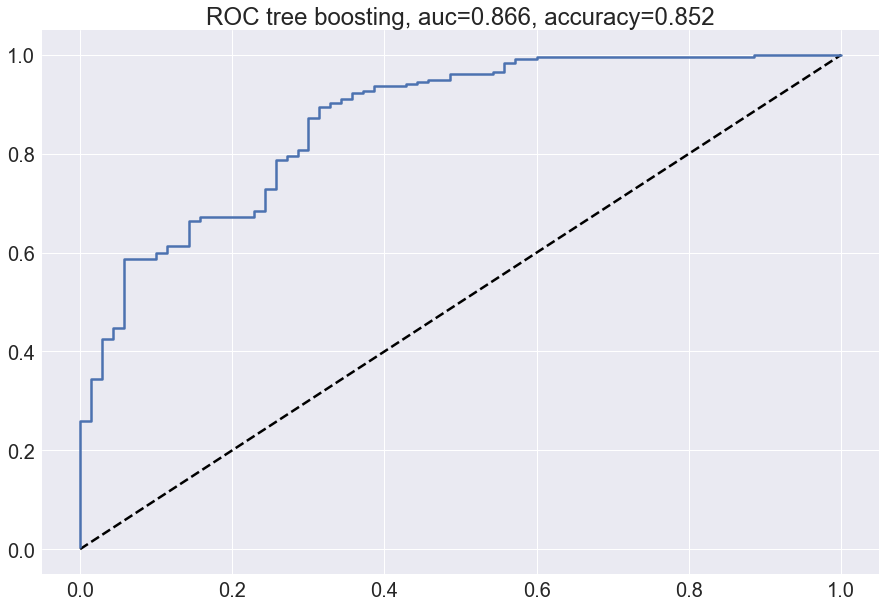

In [16]:
model = xgb.XGBClassifier(learning_rate=0.125, max_depth=3, n_estimators=400)
model.fit(X, y)

fig, ax = plt.subplots(figsize=(15,10))
_ = plt.xticks(rotation=90)

features = sorted(zip(X.columns.values, model.feature_importances_), key = lambda x: x[1], reverse=True)

sns.barplot([f[0] for f in features], [f[1] for f in features])
acc = np.mean(cross_val_score(model, X, y, scoring='accuracy', cv=5))
plt.title('Feature importance')


probs = cross_val_predict(model, X, y, method='predict_proba', cv=5)[:,1]
fpr, tpr, _ = roc_curve(y, probs)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(15,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title('ROC tree boosting, auc={}, accuracy={}'.format(round(auc_score, 3), round(acc, 3)))

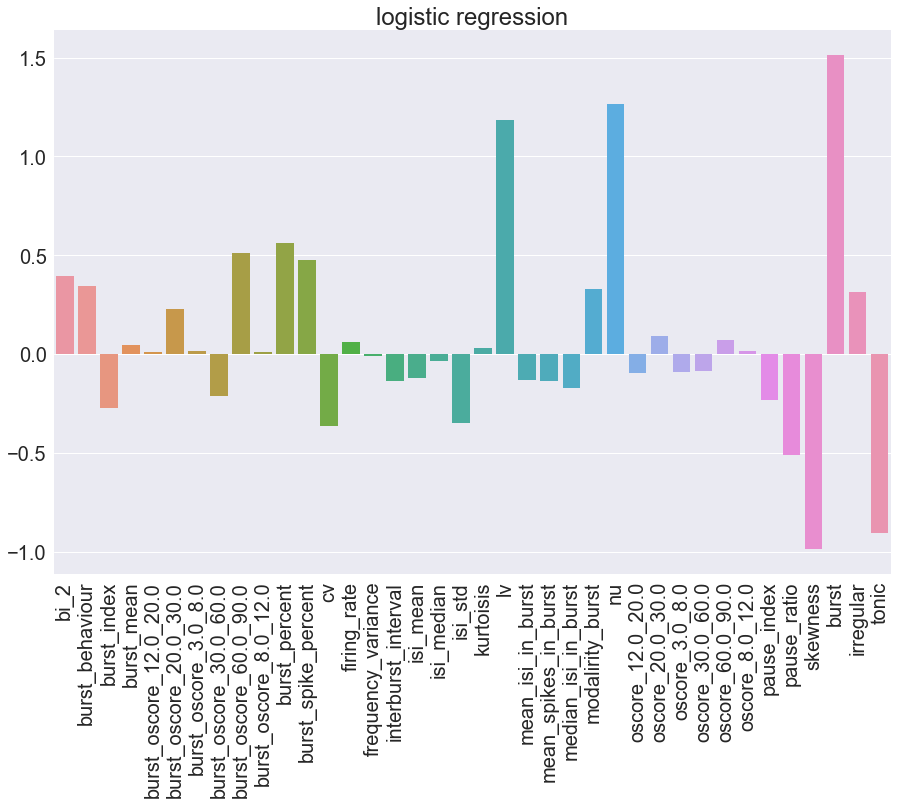

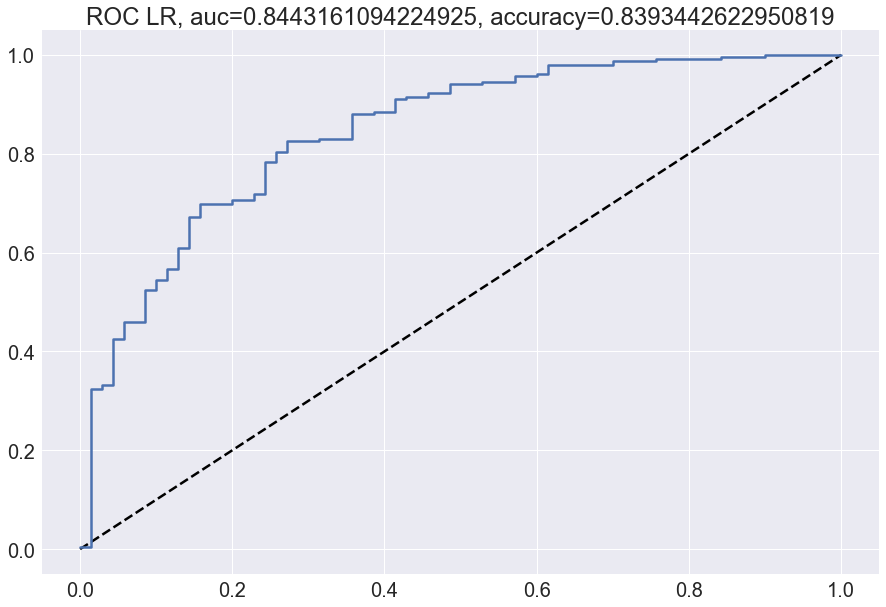

In [17]:
LR = LogisticRegression()
LR.fit(X, y)

plt.figure(figsize=(15,10))
plt.xticks(rotation=90)
sns.barplot(X.columns.values, LR.coef_[0])
acc = np.mean(cross_val_score(LR, X, y, scoring='accuracy', cv=5))
plt.title('logistic regression')

probs = cross_val_predict(LR, X, y, method='predict_proba', cv=5)[:,1]
fpr, tpr, _ = roc_curve(y, probs)
auc_score = auc(fpr, tpr)

plt.figure(figsize=(15,10))
plt.xticks(rotation=0)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.title('ROC LR, auc={}, accuracy={}'.format(auc_score, acc))

In [31]:
burst_oscores = ['burst_oscore_12.0_20.0', 'burst_oscore_20.0_30.0',
       'burst_oscore_3.0_8.0', 'burst_oscore_30.0_60.0',
       'burst_oscore_60.0_90.0', 'burst_oscore_8.0_12.0']

In [32]:
for b in burst_oscores:
    data_sleep = data_sleep[data_sleep[b] != 0.]
    data_awake = data_awake[data_awake[b] != 0.]

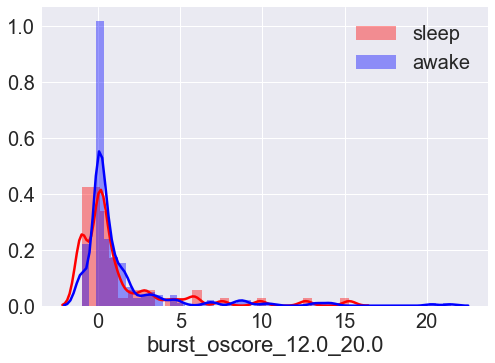

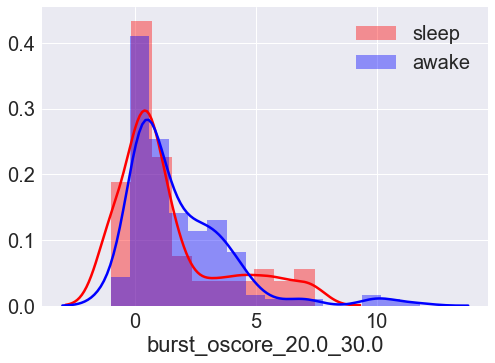

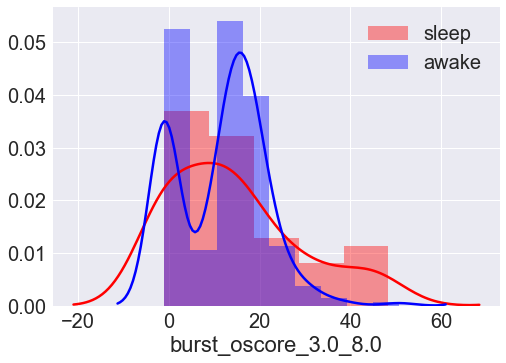

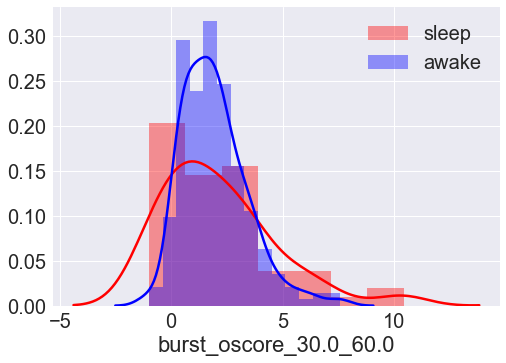

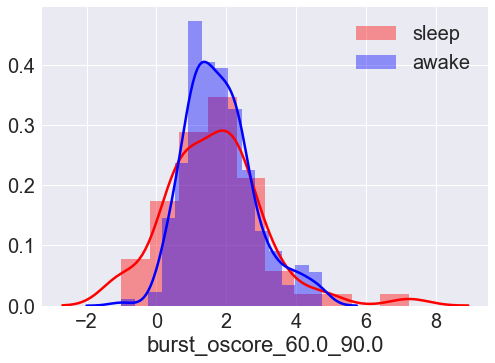

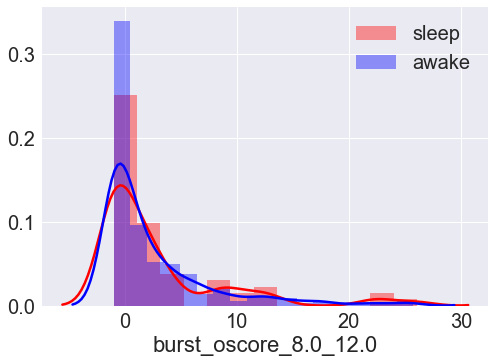

In [33]:
for b in burst_oscores:
    plt.figure()
    sns.distplot(data_sleep[b], color='red', label='sleep')
    sns.distplot(data_awake[b], color='blue', label='awake')
    plt.legend()

c:\Users\vladka\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


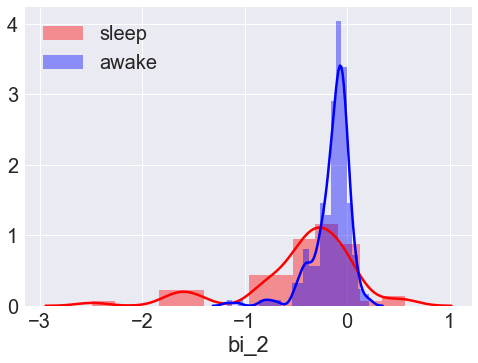

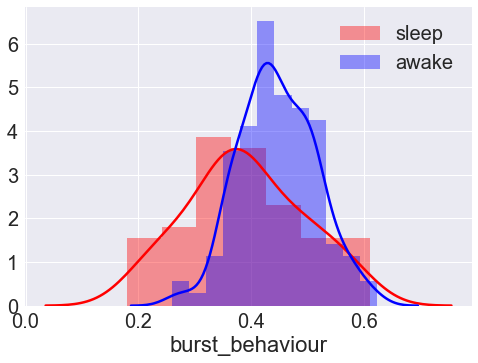

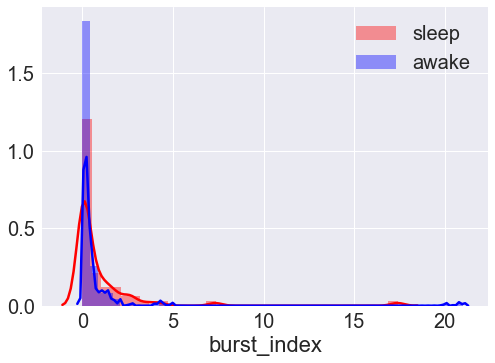

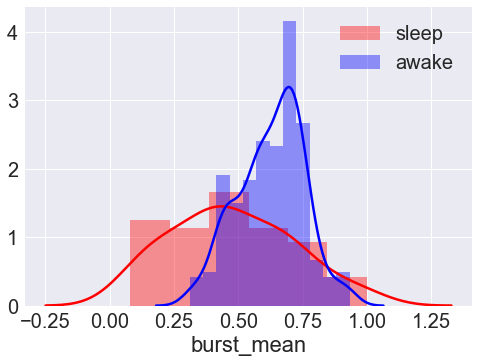

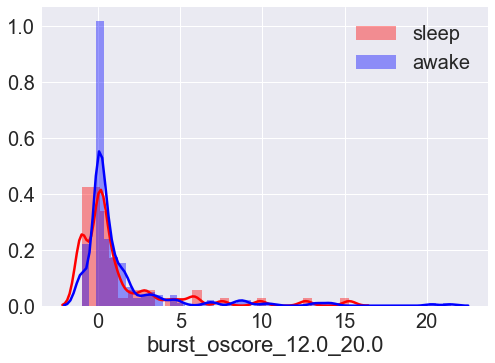

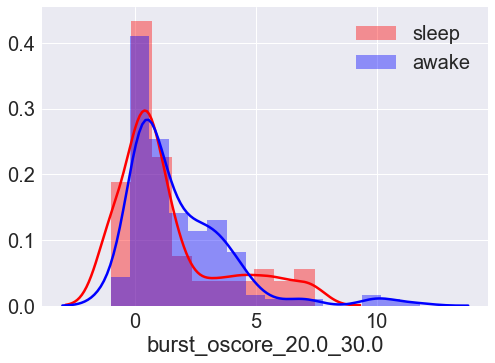

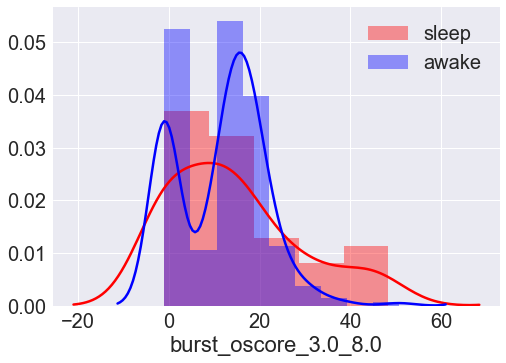

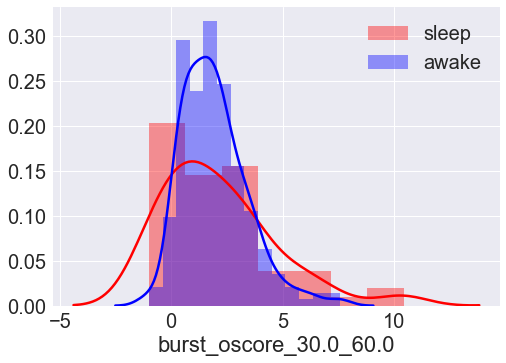

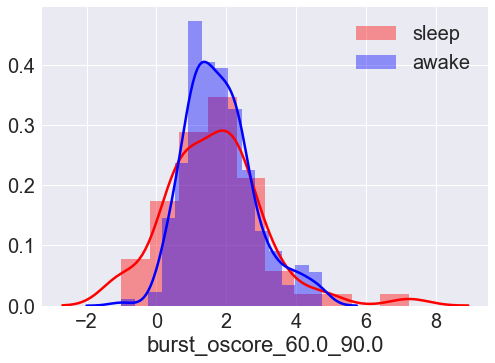

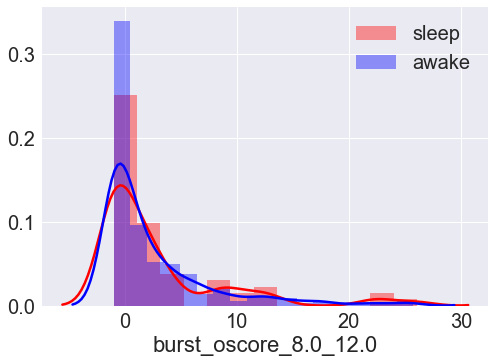

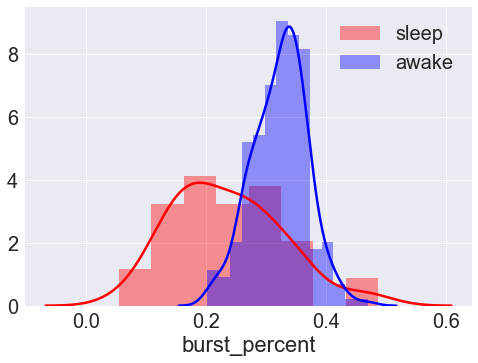

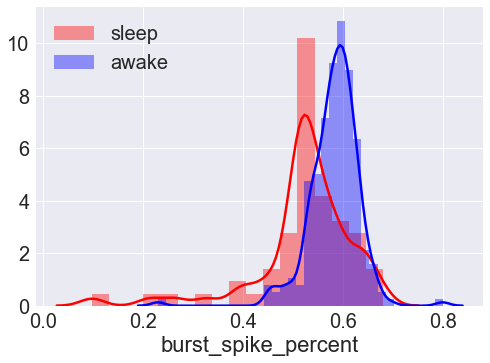

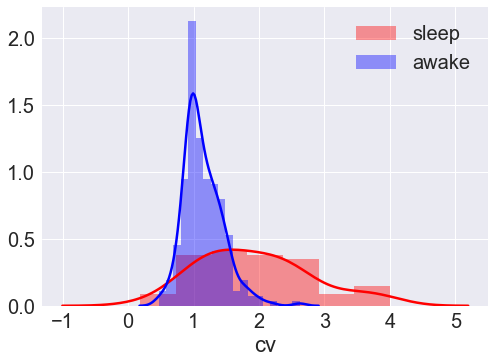

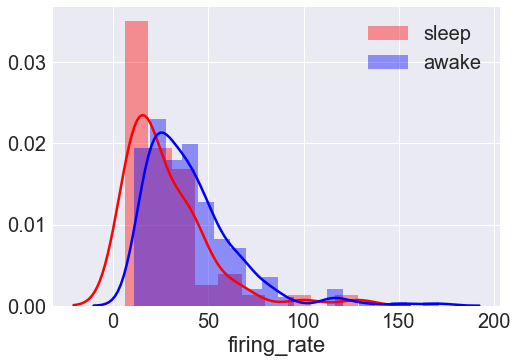

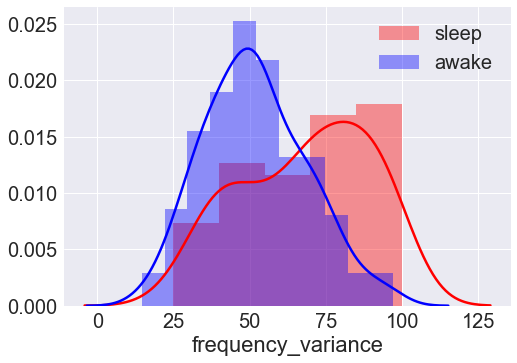

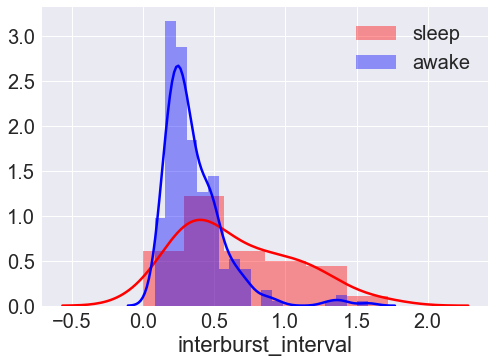

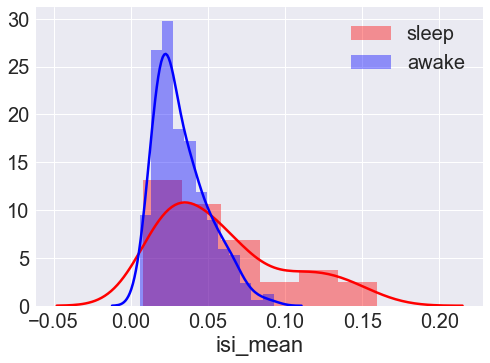

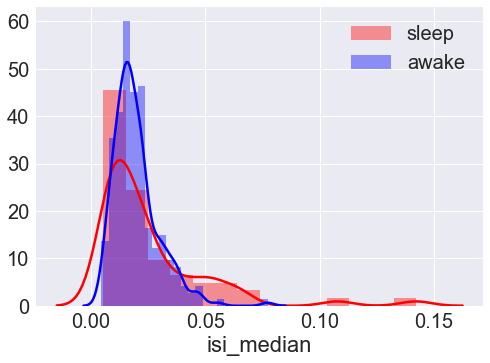

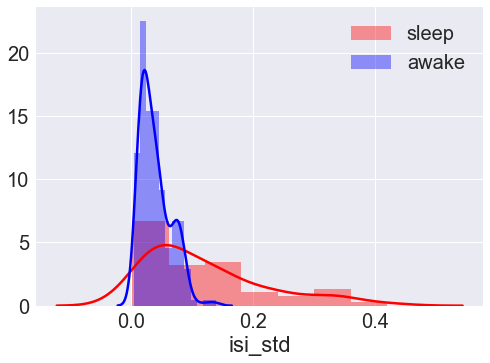

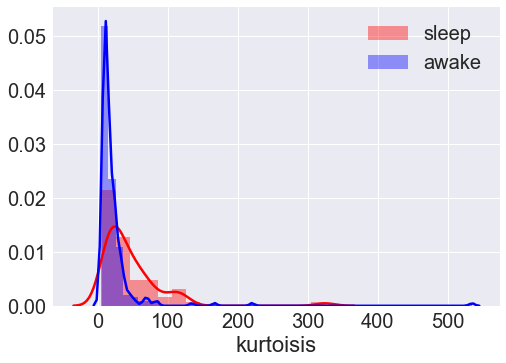

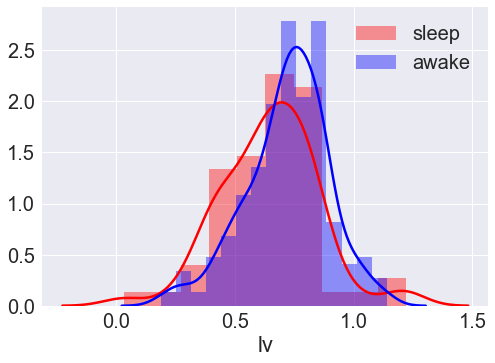

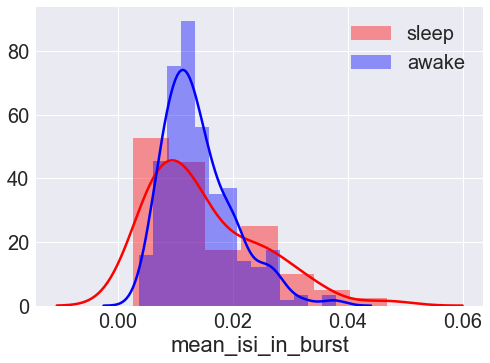

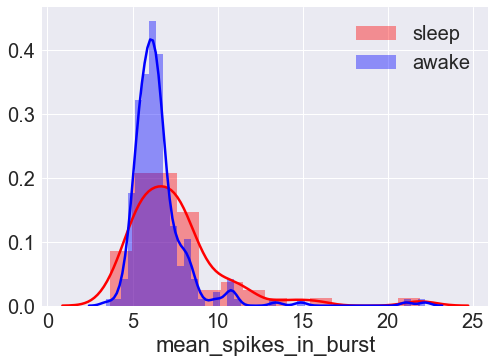

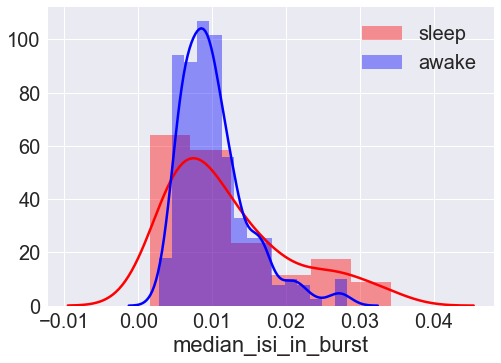

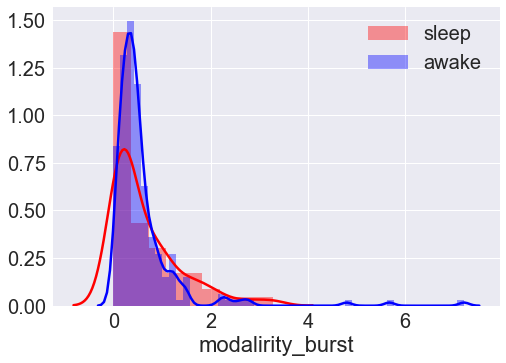

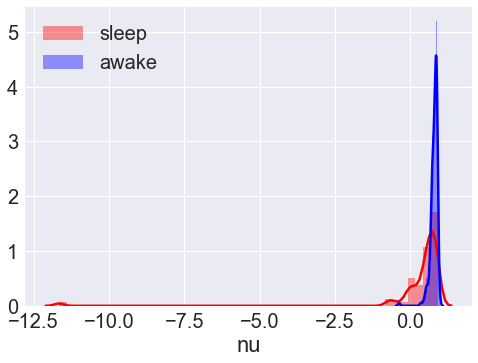

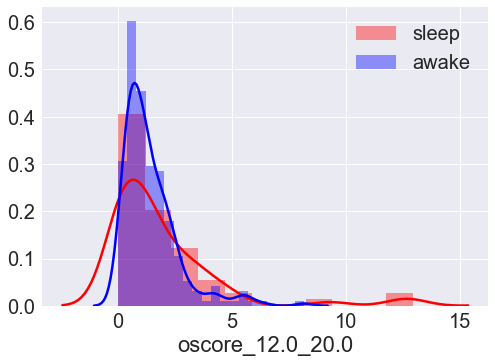

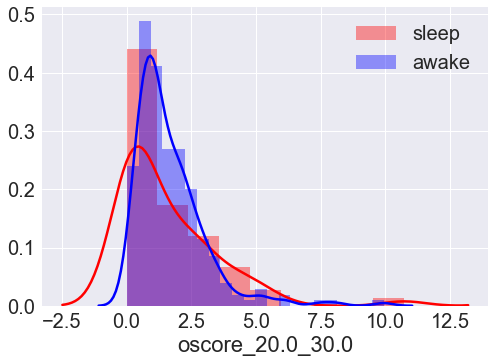

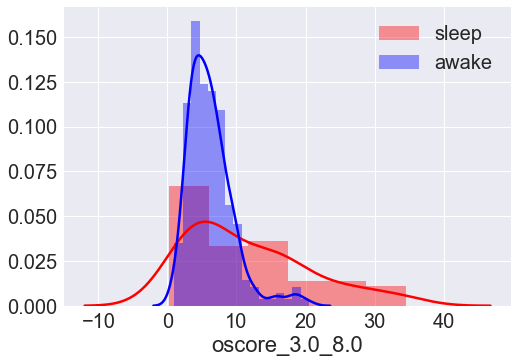

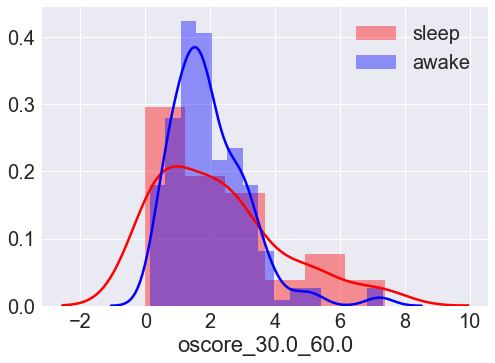

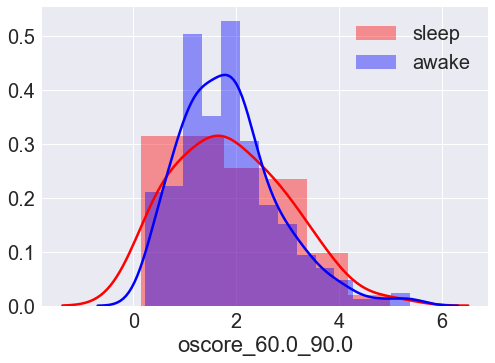

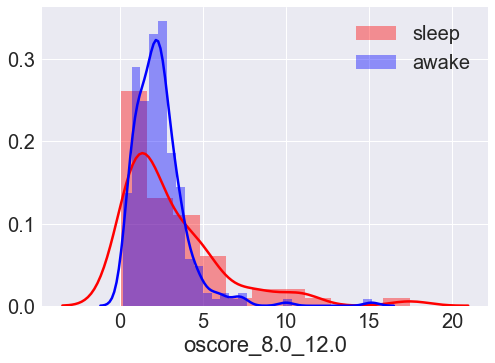

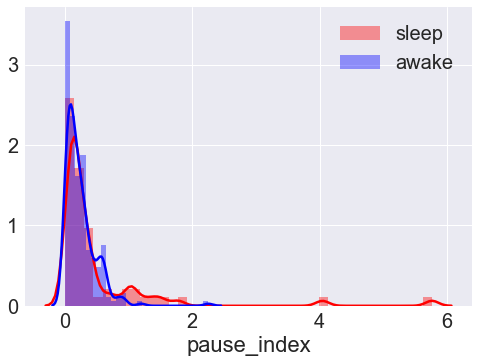

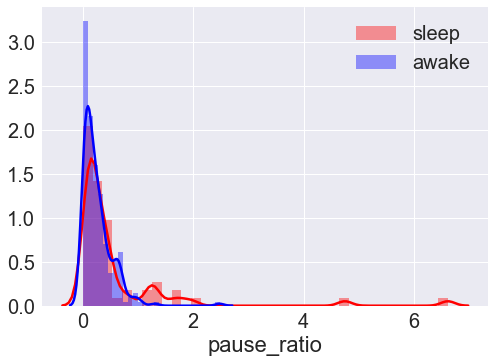

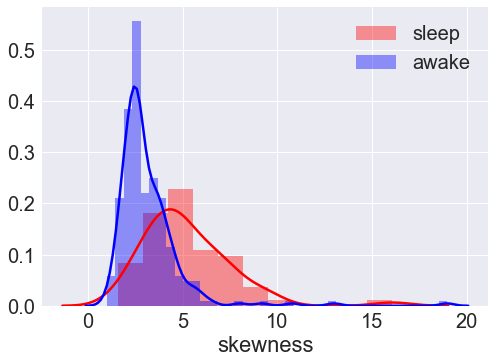

In [34]:
for f in data.drop(['awake', 'burst', 'tonic', 'irregular'], axis=1).columns.values:
    plt.figure()
    sns.distplot(data_sleep[f], color='red', label='sleep')
    sns.distplot(data_awake[f], color='blue', label='awake')
    plt.legend()

In [44]:
# sns.pairplot(data, hue='type', size=5)

In [26]:
model = Lasso()
model.fit(X, y)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [29]:
for f_name,zip(X.columns.values, model.coef_)